In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # 目標
 執行 tf-idf, Cluster, PCA 看看是否能讓機器看到一篇產業新聞的時候自動幫它分類
 # 步驟
 1. 導入[爬蟲結果](./crawler/tech_orange.ipynb)
 2. 導入[Jieba斷句結果](./dictionary/news_to_seg.ipynb)
 3. tf-idf 計算文字與文章的關聯並紀錄權重
 4. Cluster 將結果分為五群，看看分群解果能不能大致將產業分別開來
 5. PCA 將 tf-idf 的結果降維並根據 Cluster 結果繪製散步圖

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def tf_idf_weight(filelist=["ecommerce", "blockchain", "finance", "marketing", "travel"]):
    corpus = []
    for one_file in filelist:
        f = open("./dictionary/data/" + one_file + "_seg.txt", "r+", encoding="utf-8")
        content = f.read()
        f.close()
        content = content.split("\n")
        # Drop blank
        del content[-1]
        corpus.extend(content)

    vectorizer = CountVectorizer()  
    X = vectorizer.fit_transform(corpus)  
    transformer = TfidfTransformer()  
    tfidf = transformer.fit_transform(X)
    print(len(corpus))

    word = vectorizer.get_feature_names()
    weight = tfidf.toarray()
    print(len(word))
    print(len(weight))

    f = open("./tfidf_cluster_pca/tfidf/industry_words.txt", "w+", encoding="utf-8")
    for i in range(len(word)):
        f.write(word[i]+" ")
    f.write("\n")
    f.close()

    f = open("./tfidf_cluster_pca/tfidf/industry_words_tfidf_weight.txt", "w+", encoding="utf-8")
    for i in range(len(weight)):
        for j in range(len(word)):
            f.write(str(weight[i][j])+" ")
        f.write("\n")
    f.close()

    return(weight)

def load_data(filelist=["ecommerce", "blockchain", "finance", "marketing", "travel"], labellist=["電商", "區塊練", "金融", "行銷", "旅遊"]):
    mega_data = pd.DataFrame()
    for i in range(len(filelist)):
        with open("./crawler/data/tech_orange_" + filelist[i] + ".pkl", "rb") as handle:
            data = pickle.load(handle)
        data = data[::-1]
        data = pd.DataFrame(data)
        data["label"] = labellist[i]
        mega_data = pd.concat([mega_data, data])
    return(mega_data)


In [3]:
weight = tf_idf_weight()
data = load_data()


399
32831
399


In [4]:
number_of_clusters = 20
clf = KMeans(n_clusters=number_of_clusters)
clf.fit(weight)
pre = clf.predict(weight)
print(len(pre))

pca = PCA(n_components=2)
trans_data = pca.fit_transform(weight)
print(len(trans_data))

data["category"] = pd.DataFrame(pre)
data["pca1"] = pd.DataFrame(trans_data[:,0])
data["pca2"] = pd.DataFrame(trans_data[:,1])
data.to_pickle("./tfidf_cluster_pca/data_cluster_and_pca.pkl")


399
399


In [5]:
f = open("./tfidf_cluster_pca/cluster/cluster.txt", "w+", encoding="utf-8")
for i in range(number_of_clusters):
    one_category = data.loc[data["category"] == i]
    f.write("[Category: " + str(i) + "]\n")
    for each_row, each_title in one_category.iterrows():
        f.write(each_title["label"] + " " + each_title["title"] + "\n")
    f.write("\n")
f.close()


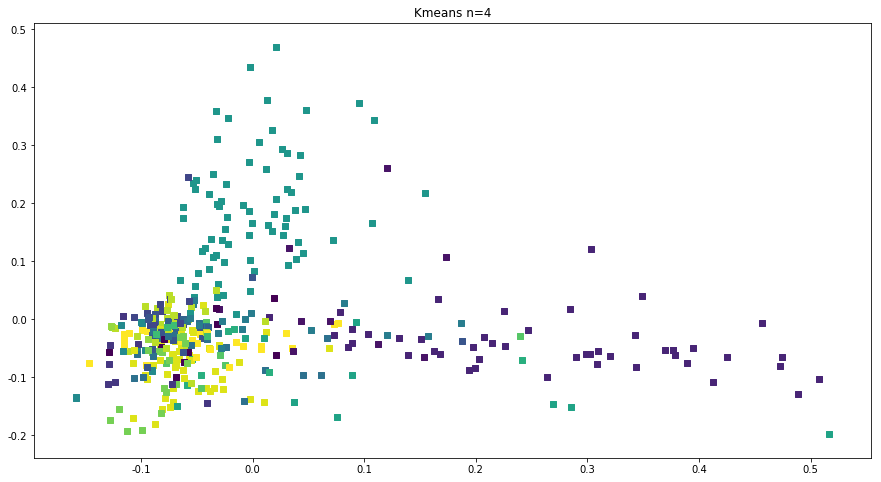

In [6]:
plt.figure(figsize=(15, 8))
plt.rcParams["axes.unicode_minus"]=False 
plt.title(u"Kmeans n=4")
plt.scatter(trans_data[:,0],trans_data[:,1],c=pre,marker="s")